In [3]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import tqdm as tq
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
import winsound
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
Freq = 1000 # Set Frequency To 2500 Hertz
Dur = 1000 # Set Duration To 1000 ms == 1 second

In [2]:
eta=1
R=t.pi
weight=1
BW=10

def V(x):
    return (1/2)*((x-R/2)**30)


ReLu=t.nn.ReLU()

def act(x):
    return t.sin(x) 
#t.tanh(x)
#t.sin(x) 
#t.exp(-x**2)
#t.sin(x)
#t.log(1+t.exp(x))

def dact(x):
    return t.cos(x)
#1/(t.cosh(x)**2)
#t.cos(x)
#-2*x*t.exp(-x**2)
#t.cos(x)
#t.exp(x)/(1+t.exp(x))

def ddact(x):
    return -t.sin(x)
#-2*(t.sinh(x))/(t.cosh(x)**3)
#-t.sin(x)
#-2*t.exp(-x**2)+4*(x**2)*t.exp(-x**2)
#-t.sin(x)
#t.exp(x)/((1+t.exp(x))**2)

def dddact(x):
    return -t.cos(x)
#-2*(t.cosh(x)**2-3*t.sinh(x)**2)/(t.cosh(x)**4)
#-t.cos(x)
#4*x*t.exp(-x**2)+8*x*t.exp(-x**2)-8*(x**3)*t.exp(-x**2)
#-t.cos(x)
#(t.exp(x)*(1-t.exp(x)))/(1+t.exp(x))**4

def net(c,w,b,x):
    return t.matmul(c,act(w*x+b))

def dnet(c,w,b,x):
    return t.matmul(c*w,dact(w*x+b))

def ddnet(c,w,b,x):
    return t.matmul(c*w*w,ddact(w*x+b))

def PINN_Error(c,w,b,x):
    a=0
    N=x.size(0)
    e_val=eigenvalue(c,w,b,x)
    for i in range(N):
        s=-ddnet(c,w,b,x[i])+V(x[i])*net(c,w,b,x[i])+eta*(net(c,w,b,x[i])**3)-e_val*net(c,w,b,x[i])
        a=a+(s)**2
    return (R/N)*a

        
def energy(c,w,b,x):
    e=0
    N=x.size(0)
    for i in range(N):
        e=e+(dnet(c,w,b,x[i])**2)+V(x[i])*(net(c,w,b,x[i])**2)+(eta/2)*(net(c,w,b,x[i])**4)
    e=(R/N)*e
    return e


def eigenvalue(c,w,b,x):
    e=0
    N=x.size(0)
    for i in range(N):
        e=e+(dnet(c,w,b,x[i])**2)+V(x[i])*(net(c,w,b,x[i])**2)+eta*(net(c,w,b,x[i])**4)
    e=(R/N)*e
    return e

def L2(c,w,b,x):
    a=0
    n=x.size(0)
    for i in range(n):
        a=a+net(c,w,b,x[i])**2
    return (R/n)*a
    
def Lag(c,w,b,x,L):
    return energy(c,w,b,x)+L*(L2(c,w,b,x)-1)
    
    
def Error_T(c,w,b,x):
    return energy(c,w,b,x)+(L2(c,w,b,x)-1)**2+net(c,w,b,t.zeros(1))**2+net(c,w,b,R)**2
    
    
def grad(c,w,b,x):
    m=c.size(0)
    N=x.size(0)
    grad_c=t.zeros(m)
    grad_w=t.zeros(m)
    grad_b=t.zeros(m)
    for i in range(N):
        c_1=2*dnet(c,w,b,x[i])*(w*dact(w*x[i]+b))
        c_2=2*V(x[i])*net(c,w,b,x[i])*act(w*x[i]+b)
        c_3=4*(eta/2)*(net(c,w,b,x[i])**3)*act(w*x[i]+b)
        c_b=2*net(c,w,b,R)*act(w*R+b)
        c_o=2*net(c,w,b,t.zeros(1))*act(w*t.zeros(1)+b)
        c_n=4*(L2(c,w,b,x)-1)*net(c,w,b,x[i])*act(w*x[i]+b)
        w_1=2*dnet(c,w,b,x[i])*c*(dact(w*x[i]+b)+w*ddact(w*x[i]+b)*x[i])
        w_2=2*V(x[i])*net(c,w,b,x[i])*c*dact(w*x[i]+b)*x[i]
        w_3=4*(eta/2)*(net(c,w,b,x[i])**3)*c*dact(w*x[i]+b)*x[i]
        w_b=2*net(c,w,b,R)*c*dact(w*R+b)*R
        w_o=2*net(c,w,b,t.zeros(1))*c*dact(w*t.zeros(1)+b)*t.zeros(1)
        w_n=4*(L2(c,w,b,x)-1)*net(c,w,b,x[i])*c*dact(w*x[i]+b)*x[i]
        b_1=2*dnet(c,w,b,x[i])*c*(w*ddact(w*x[i]+b))
        b_2=2*V(x[i])*net(c,w,b,x[i])*c*dact(w*x[i]+b)
        b_3=4*(eta/2)*(net(c,w,b,x[i])**3)*c*dact(w*x[i]+b)
        b_b=2*net(c,w,b,R)*c*dact(w*R+b)
        b_o=2*net(c,w,b,t.zeros(1))*c*dact(w*t.zeros(1)+b)
        b_n=4*(L2(c,w,b,x)-1)*net(c,w,b,x[i])*c*dact(w*x[i]+b)
        grad_c=grad_c+c_1+c_2+c_3+BW*c_b+BW*c_o+weight*c_n
        grad_w=grad_w+w_1+w_2+w_3+BW*w_b+BW*w_o+weight*w_n
        grad_b=grad_b+b_1+b_2+b_3+BW*b_b+BW*b_o+weight*b_n
    grad_c=(R/N)*grad_c
    grad_w=(R/N)*grad_w
    grad_b=(R/N)*grad_b
    return grad_c, grad_w, grad_b
    
    
def optimization(N,m,T,r):
    c=t.zeros(m)
    w=t.zeros(m)
    b=t.zeros(m)
    c[0]=1
    w[0]=1
    b[0]=1
    x=t.tensor([R*(i/N)  for i in range(N+1)])
    Error=t.zeros(T)
    Error_1=t.zeros(T)
    Error_2=t.zeros(T)
    Error_3=t.zeros(T)
    plots=[]
    for k in tq.tqdm(range(T)):
        y=x[1:N]
        G=grad(c,w,b,y)
        c=c-r*G[0]
        w=w-r*G[1]
        b=b-r*G[2]
        rc_L2=L2(c,w,b,x)
        a=t.tensor([net(c,w,b,x[i]) for i in range(N+1)])
        Sa=t.sign(a)*t.sign(a)
        G=0
        for i in range(N-2):
            G=G+(Sa[i+1]-1)
        if G==0:
            c=c/t.sqrt(rc_L2)
        Error[k]=energy(c,w,b,x)
        Error_1[k]=PINN_Error(c,w,b,x)
        Error_2[k]=rc_L2
        Error_3[k]=Error_T(c,w,b,x)
        if np.isnan(Error[k])==True:
            break
        #s=t.tensor([t.sign(net(c,w,x[i])) for i in range(N)])
        plt.plot(x,a)
        plt.xlabel(str(k)+"/"+str(T))
        plt.ylabel("N="+str(N)+"..."+"m="+str(m)+"..."+"r="+str(r))
        if k==0:
            fig, ax = plt.figure(), plt.axes(xlim=(0, R), ylim=(-0.5, 1.5))
        else:
            dummy_fig, ax = plt.figure(), plt.axes(xlim=(0, R), ylim=(-0.5, 1.5))
            ax.set(animated=True)
            ax.remove()
            ax.figure = fig
            fig.add_axes(ax)
            plt.close(dummy_fig)
        
        plots.append([ax])

    ani = animation.ArtistAnimation(fig, plots, interval=50, repeat_delay=20000)
    ani.save("GPE_sine.gif")
    winsound.Beep(Freq,Dur)
    winsound.Beep(Freq,Dur)
    return c,w,b,Error,Error_1,Error_2, Error_3



In [ ]:
def model(N):
    def objective_grad(theta):
        thetaF=theta[:321*10]
        thetaF=thetaF.reshape(10,321)
        thetaT=theta[321*10:]
        thetaT=thetaT.reshape(10,10)
        F=-grad_feature(N,thetaF,thetaT)
        T=-grad_transition(N,thetaF,thetaT)
        gradF=np.ndarray.flatten(F)
        gradT=np.ndarray.flatten(T)
        grad=np.concatenate((gradF,gradT))
        return grad 

    def objective(theta):
        thetaF=theta[:321*10]
        thetaF=thetaF.reshape(10,321)
        thetaT=theta[321*10:]
        thetaT=thetaT.reshape(10,10)
        return -Average_LLH('train',N,thetaF,thetaT)

    def optimization():
        x0F,x0T=setup_param()
        x0F=np.ndarray.flatten(x0F)
        x0T=np.ndarray.flatten(x0T)
        x0=np.concatenate((x0F,x0T))
        #x0=np.zeros(331*10)
        return fmin_l_bfgs_b(objective, x0, fprime=objective_grad, approx_grad=0, disp=10)
    return optimization()

In [83]:
n=30
m=100
T=300
r=0.001

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [2:20:35<00:00, 28.12s/it]
MovieWriter ffmpeg unavailable; using Pillow instead.


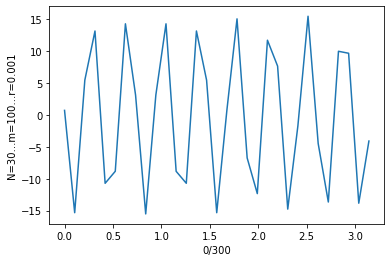

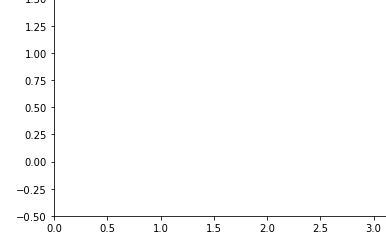

In [84]:
A=optimization(n,m,T,r)

([<matplotlib.lines.Line2D at 0x23a6001e9d0>], tensor(28869.6348))

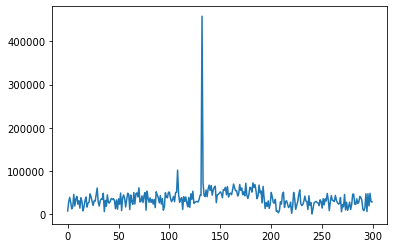

In [85]:
plt.plot(A[3]), A[3][-1]  #Energy

([<matplotlib.lines.Line2D at 0x23a600745e0>], tensor(8.8388e+09))

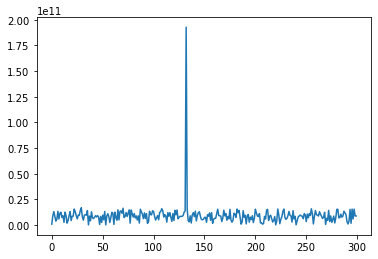

In [86]:
plt.plot(A[4]), A[4][-1]  #PINN

([<matplotlib.lines.Line2D at 0x23a602f2370>], tensor(13.5467))

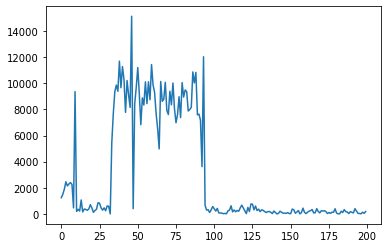

In [87]:
plt.plot(A[5][100:]), t.sqrt(A[5][-1]) #L2

([<matplotlib.lines.Line2D at 0x23a6043ab20>], tensor(28870.2734))

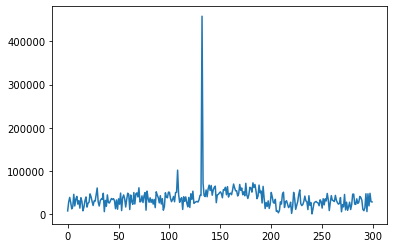

In [88]:
plt.plot(A[6]), A[6][-1] #Total Error

In [89]:
x=t.tensor([(i/n)*t.pi  for i in range(n+1)])
L2(A[0],A[1],A[2],x)

tensor(1.)

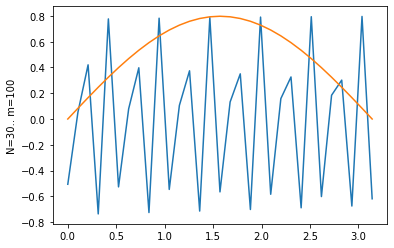

In [90]:
plt.plot(x,t.tensor([net(A[0],A[1],A[2],x[i]) for i in range(n+1)]))
plt.ylabel("N="+str(n)+ ".. " +"m="+str(m))
plt.plot(x,t.sin(x)/(t.sqrt(t.tensor(t.pi/2))))

In [91]:
Q=0
J=t.tensor([net(A[0],A[1],A[2],x[i]) for i in range(n+1)])
for i in range(n+1):
    Q=Q+(t.sin(x[i])/(t.pi/2)-J[i])**2
Q=Q/(n+1)
Q

tensor(0.5131)

In [92]:
eigenvalue(A[0],A[1],A[2],x)

tensor(28869.8730)

In [93]:
energy(A[0],A[1],A[2],x)

tensor(28869.6348)

In [94]:
net(A[0],A[1],A[2],t.pi)

tensor(-0.6192)

In [95]:
net(A[0],A[1],A[2],0)

tensor(-0.5066)

In [96]:
Q=0
H=10000
X=t.tensor([(R/n)*i for i in range(H+1)])
for i in range(H+1):
    Q=Q+(t.sin(X[i]))**2
Q=Q*(R/(H+1))
Q*(2/t.pi)

tensor(0.9996)

In [97]:
net(A[0],A[1],A[2],t.pi)

tensor(-0.6192)